In [32]:
from osgeo import gdal
import fiona
import geopandas
import pandas as pd
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import numpy as np
import os
import glob
import geopandas as gpd
from shapely.geometry import Point

In [9]:
# Read the text file into a DataFrame
df = pd.read_csv('C:/Users/hughr/OneDrive/Documents/RMI/EDGAR/SWD_LDF_txt/v7.0_FT2021_CH4_2021_SWD_LDF.txt', delimiter=';', skiprows=2)

# Rename the columns
df.columns = ['lat', 'lon', 'emission_2021_tons']

# Print the DataFrame
print(df)

         lat    lon  emission_2021_tons
0       72.7  -56.2           36.804000
1       72.6  -78.0            0.195822
2       72.2   82.3            6.349060
3       71.9  102.4           25.749000
4       71.9  102.5            6.371110
...      ...    ...                 ...
256255 -53.9  -67.7           47.202800
256256 -54.8  -68.3           91.833500
256257 -54.9  -68.4          159.321000
256258 -54.9  -68.3           85.346100
256259 -55.0  -67.7            7.706810

[256260 rows x 3 columns]


In [10]:
# Create a new GeoDataFrame with a 'geometry' column
df_geo = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.lon, df.lat))

C:\ProgramData\anaconda3\envs\benjamin\lib\site-packages\geopandas\array.py:275: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  return GeometryArray(vectorized.points_from_xy(x, y, z), crs=crs)


In [ ]:
# # Can use this but it's slow
# df['geometry'] = [Point(xy) for xy in zip(df.lon, df.lat)]
# df_geo = gpd.GeoDataFrame(df, geometry='geometry')

In [11]:
# Load province borders
geopackage_file_path = 'C:/Users/hughr/OneDrive/Documents/RMI/GADM/gadm_410-levels.gpkg'
province_borders = geopandas.read_file(geopackage_file_path, layer='ADM_1')
province_borders

,GID_0,COUNTRY,GID_1,NAME_1,VARNAME_1,NL_NAME_1,TYPE_1,ENGTYPE_1,CC_1,HASC_1,ISO_1,geometry
0,AFG,Afghanistan,AFG.1_1,Badakhshan,Badahšan,NA,Velayat,Province,NA,AF.BD,NA,"MULTIPOLYGON (((71.11366 35.97130, 71.10155 35..."
1,AFG,Afghanistan,AFG.2_1,Badghis,Badghes|Badghisat|Badgis,NA,Velayat,Province,NA,AF.BG,AF-BDG,"MULTIPOLYGON (((63.76845 34.52948, 63.75823 34..."
2,AFG,Afghanistan,AFG.3_1,Baghlan,Baglan|Bughlan,NA,Velayat,Province,NA,AF.BL,AF-BGL,"MULTIPOLYGON (((68.05261 35.08151, 68.03890 35..."
3,AFG,Afghanistan,AFG.4_1,Balkh,Balh|Mazar-i-Sharif|Mazar,NA,Velayat,Province,NA,AF.BK,AF-BAL,"MULTIPOLYGON (((67.11067 36.00776, 67.14209 35..."
4,AFG,Afghanistan,AFG.5_1,Bamyan,NA,NA,Velayat,Province,NA,AF.BM,AF-BAM,"MULTIPOLYGON (((67.30598 34.38105, 67.32777 34..."
...,...,...,...,...,...,...,...,...,...,...,...,...
3657,ZWE,Zimbabwe,ZWE.6_1,Mashonaland West,NA,NA,Province,Province,NA,ZW.MW,ZW-MW,"MULTIPOLYGON (((30.60252 -18.76013, 30.59981 -..."
3658,ZWE,Zimbabwe,ZWE.7_1,Masvingo,NA,NA,Province,Province,NA,ZW.MV,ZW-MV,"MULTIPOLYGON (((31.30838 -22.41957, 31.30462 -..."
3659,ZWE,Zimbabwe,ZWE.8_1,Matabeleland North,NA,NA,Province,Province,NA,ZW.MN,ZW-MN,"MULTIPOLYGON (((28.66326 -20.16527, 28.66392 -..."
3660,ZWE,Zimbabwe,ZWE.9_1,Matabeleland South,NA,NA,Province,Province,NA,ZW.MS,ZW-MS,"MULTIPOLYGON (((30.23714 -22.30056, 30.23706 -..."


In [13]:
# Set crs, perform a spatial join
df_geo = df_geo.set_crs("EPSG:4326")
joined = gpd.sjoin(df_geo, province_borders, how='inner', op='within')

In [16]:
# Group by province and calculate sum
emi_sum = joined.groupby('NAME_1')['emission_2021_tons'].sum()

# Add to provinces DataFrame
province_borders.set_index('NAME_1', inplace=True)
province_borders['emi_sum'] = emi_sum

In [15]:
joined

,lat,lon,emission_2021_tons,geometry,index_right,GID_0,COUNTRY,GID_1,NAME_1,VARNAME_1,NL_NAME_1,TYPE_1,ENGTYPE_1,CC_1,HASC_1,ISO_1
1,72.6,-78.0,0.195822,POINT (-78.00000 72.60000),440,CAN,Canada,CAN.8_1,Nunavut,NA,NA,Territoire,Territory,62,CA.NU,CA-NU
114,69.1,-105.1,0.634621,POINT (-105.10000 69.10000),440,CAN,Canada,CAN.8_1,Nunavut,NA,NA,Territoire,Territory,62,CA.NU,CA-NU
152,68.7,-81.3,0.186103,POINT (-81.30000 68.70000),440,CAN,Canada,CAN.8_1,Nunavut,NA,NA,Territoire,Territory,62,CA.NU,CA-NU
215,67.8,-115.2,0.119149,POINT (-115.20000 67.80000),440,CAN,Canada,CAN.8_1,Nunavut,NA,NA,Territoire,Territory,62,CA.NU,CA-NU
384,66.1,-65.8,0.190782,POINT (-65.80000 66.10000),440,CAN,Canada,CAN.8_1,Nunavut,NA,NA,Territoire,Territory,62,CA.NU,CA-NU
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
256252,-53.8,-67.8,199.422000,POINT (-67.80000 -53.80000),121,ARG,Argentina,ARG.23_1,Tierra del Fuego,Feuerland|Terra del Fuoco|Terre,NA,Provincia,Province,NA,AR.TF,AR-V
256253,-53.8,-67.7,79.504400,POINT (-67.70000 -53.80000),121,ARG,Argentina,ARG.23_1,Tierra del Fuego,Feuerland|Terra del Fuoco|Terre,NA,Provincia,Province,NA,AR.TF,AR-V
256254,-53.9,-67.8,69.976300,POINT (-67.80000 -53.90000),121,ARG,Argentina,ARG.23_1,Tierra del Fuego,Feuerland|Terra del Fuoco|Terre,NA,Provincia,Province,NA,AR.TF,AR-V
256255,-53.9,-67.7,47.202800,POINT (-67.70000 -53.90000),121,ARG,Argentina,ARG.23_1,Tierra del Fuego,Feuerland|Terra del Fuoco|Terre,NA,Provincia,Province,NA,AR.TF,AR-V


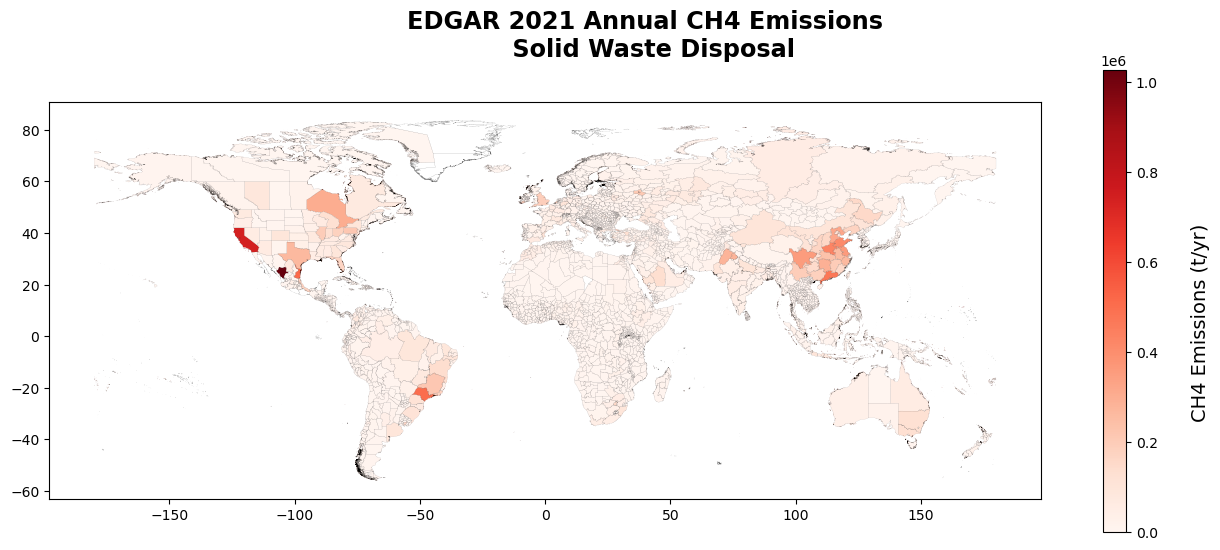

In [23]:
# Plot
fig, ax = plt.subplots(figsize = (16,6))
fig.suptitle('EDGAR ' + '2021' + ' Annual CH4 Emissions \n Solid Waste Disposal', fontsize = 'xx-large', fontweight = 'bold')

# Map the EDGAR values for chosen year
province_borders.plot(column='emi_sum', cmap='Reds', ax=ax, legend=True, vmin=0)

# Add country borders
province_borders.boundary.plot(ax=ax, color='black', linewidth=.03)
plt.text(0.839, 0.3, 'CH4 Emissions (t/yr)', rotation = 90,fontsize=14, transform=plt.gcf().transFigure)
plt.show()

save_path = 'C:/Users/hughr/OneDrive/Documents/RMI/map_v1/'
fig.savefig(save_path + 'provinces.png', dpi=600, format='png', bbox_inches='tight')

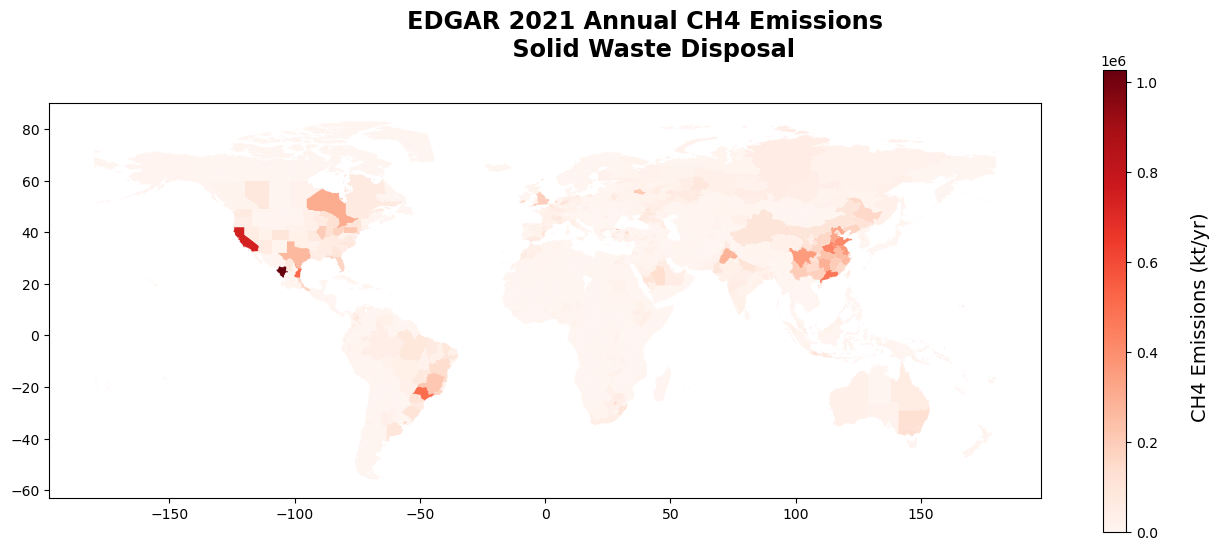

In [19]:
# Plot without borders if you want. 

fig, ax = plt.subplots(figsize = (16,6))
fig.suptitle('EDGAR ' + '2021' + ' Annual CH4 Emissions \n Solid Waste Disposal', fontsize = 'xx-large', fontweight = 'bold')

# Map the EDGAR values for chosen year
province_borders.plot(column='emi_sum', cmap='Reds', ax=ax, legend=True, vmin=0)

# Add country borders
#province_borders.boundary.plot(ax=ax, color='black', linewidth=.1)
plt.text(0.839, 0.3, 'CH4 Emissions (kt/yr)', rotation = 90,fontsize=14, transform=plt.gcf().transFigure)
plt.show()